# Crop Segmentation

This notebook is a part of the [Crop Segmentation and Classification](crop-segmentation-and-classification.ipynb) notebook project. In this notebook, we compare methods for segmentation of a Planet image into crops.

The sections are:
- [Crop Datasets to AOI](#crop)
- [Visualize Ground Truth Data over Image](#visualize)
 - [Map](#visualize-map)
 - [Image Space](#visualize-image)
3. [Segment Image](#segment)

### Usage Notes

This notebook was developed in a Docker container. This [Dockerfile](Dockerfile) was used to build the image.

## Setup

In [1]:
# Notebook dependencies
from __future__ import print_function

import copy
from collections import namedtuple
from functools import partial
import json
import os
import subprocess
import tempfile
from xml.dom import minidom

import cv2
import ipyleaflet as ipyl
import ipywidgets as ipyw
from IPython.display import display, Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pyproj
import rasterio
from shapely.geometry import shape, mapping
from shapely.geometry.geo import box
from shapely.ops import transform
from skimage import segmentation

%matplotlib inline

### Input Data Specification

In [3]:
# These datasets are created in identify-datasets notebook
data_folder = 'data'
pl_filename = os.path.join(data_folder, '20160831_180231_0e0e_3B_AnalyticMS.tif')
assert os.path.isfile(pl_filename)

pl_metadata_filename = os.path.join(data_folder, '20160831_180231_0e0e_3B_AnalyticMS_metadata.xml')
assert os.path.isfile(pl_metadata_filename)

aoi_filename = os.path.join(data_folder, 'aoi.geojson')
assert os.path.isfile(aoi_filename)

ground_truth_filename = os.path.join(data_folder, 'ground-truth.geojson')
assert os.path.isfile(ground_truth_filename)

### Utilities

Functions that will be used within this notebook. Gathered here to reduce code overhead within the notebook and to support the eventual migration of these functions into separate modules. 

In [4]:
# run the tests for the utility functions?
# TEST = True
TEST = False

#### Vector Utilities

feature geospatial utilities

In [5]:
# Uses shapely for geospatial operations
def crop_polygons_to_aoi(polygons, aoi):
    """Crops polygons to the aoi.
    
    Polygons within aoi are copied. For Polygons that intersect aoi boundary, the 
    intersection geometry is saved. If the intersection is a MultiPolygon, it is
    stored as multiple Polygons.
    
    :param dict aoi: geojson polygon describing crop feature
    :param list features: geojson polygons to be cropped
    """
    aoi_shp = shape(aoi['geometry'])
    cropped_features = []
    for f in polygons:
        shp = shape(f['geometry'])
        assert shp.type == 'Polygon'
        
        if shp.within(aoi_shp):
            cropped_features.append(copy.deepcopy(f))
        elif shp.intersects(aoi_shp):
            # 'cut' features at the aoi boundary by the aoi
            cropped_shp = shp.intersection(aoi_shp)
            
            try:
                # try to iterate, which only works for MultiPolygon
                for s in cropped_shp:
                    new_f = copy.deepcopy(f)
                    new_f['geometry'] = mapping(s)
                    cropped_features.append(new_f)
            except TypeError:
                # Polygon is not iterable
                new_f = copy.deepcopy(f)
                new_f['geometry'] = mapping(cropped_shp)
                cropped_features.append(new_f)
    return cropped_features

def test_crop_polygons_to_aoi():
    aoi = json.load(open(aoi_filename, 'r'))
    polygons = json.load(open(ground_truth_filename))
    print(len(crop_polygons_to_aoi(polygons, aoi)))
if TEST: test_crop_polygons_to_aoi()


def project_feature(feature, proj_fcn):
    """Creates a projected copy of the feature.
    
    :param feature: geojson description of feature to be projected
    :param proj_fcn: partial function defining projection transform"""
    g1 = shape(feature['geometry'])
    g2 = transform(proj_fcn, g1)
    proj_feat = copy.deepcopy(feature)
    proj_feat['geometry'] = mapping(g2)
    return proj_feat


def project_features(features, img_srs, src_srs='epsg:4326'):
    """Project features to img_srs.
    
    If src_srs is not specified, WGS84 (only geojson-supported crs) is assumed.
    
    :param features: list of geojson features to be projected
    :param str img_srs: destination spatial reference system
    :param str src_srs: source spatial reference system
    """
    # define projection
    # from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
    proj_fcn = partial(
        pyproj.transform,
        pyproj.Proj(init=src_srs),
        pyproj.Proj(init=img_srs))
    
    return [project_feature(f, proj_fcn) for f in features]


def test_project_features():
    img_srs = rasterio.open(pl_filename).crs['init']
    
    with open(ground_truth_filename, 'r') as f:
        ground_truth_data = json.load(f)
    
    projected_features = project_features(ground_truth_data, img_srs)
    print(len(projected_features))
if TEST: test_project_features()

feature/contour conversion

In [6]:
def polygon_to_contour(feature_geometry, image_transform):
    """Convert the exterior ring of a geojson Polygon feature to an
    OpenCV contour.
    
    image_transform is typically obtained from `img.transform` where 
    img is obtained from `rasterio.open()
    
    :param feature_geometry: the 'geometry' entry in a geojson feature
    :param rasterio.Affine image_transform: image transformation"""
    points_xy = shape(feature_geometry).exterior.coords
    points_x, points_y = zip(*points_xy) # inverse of zip
    rows, cols = rasterio.transform.rowcol(image_transform, points_x, points_y)
    return np.array([pnt for pnt in zip(cols, rows)], dtype=np.int32)


def test_polygon_to_contour():
    with rasterio.open(pl_filename) as img:
        img_transform = img.transform
        img_srs = img.crs['init']

    with open(ground_truth_filename, 'r') as f:
        ground_truth_data = json.load(f)
    projected_features = project_features(ground_truth_data, img_srs)
    
    contours = [polygon_to_contour(f['geometry'], img_transform)
                for f in projected_features]
    print('Success')
if TEST: test_polygon_to_contour()    

#### Raster

Utilities for loading, processing, and displaying a Planet Scene

In [7]:
# NOTE: Not sure a namedtuple is what we want long-term. It is used now because:
# memory footprint is smaller than a masked ndarray (where the same mask is repeated across all bands)
# response is faster than rasterio read(), which appears to read from the file vs. caching

# Saves the image bands and image mask separately
# Bands is a uint16 3darray representing band pixels, in RGBNir order
# Mask is a boolean 2d array identifying nodata pixels (True=nodata)
MaskedImage = namedtuple('MaskedImage', 'bands, mask')

def load_masked_image(filename):
    """Loads a 4-band RGBNir Planet Image file as a MaskedImage."""
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
        return MaskedImage(bands=np.dstack([r, g, b, nir]), mask=mask)

def test_load_masked_image():
    img = load_masked_image(pl_filename)
    print('Success')
if TEST: test_load_masked_image()

def create_masked_bands(masked_image):
    """Creates a 3d MaskedArray from a MaskedImage.
    
    The MaskedImage mask is repeated across all bands. This is inefficient for
    storage and the mask is no longer guaranteed to be the same across all bands,
    but allows the use of MaskedArray functionality.
    """
    # recast 2d mask to 3d, repeating across 3rd axis
    mask = np.broadcast_to(np.atleast_3d(masked_image.mask),
                           masked_image.bands.shape)
    return ma.masked_array(masked_image.bands, mask)

def test_create_masked_bands():
    masked_bands = create_masked_bands(load_masked_image(pl_filename))
    print('Success')
if TEST: test_create_masked_bands()

In [8]:
def _gdalwarp_crop_options(crop_filename):
    return ['-cutline', crop_filename, '-crop_to_cutline']
    
def _gdalwarp_project_options(src_proj, dst_proj):
    return ['-s_srs', src_proj, '-t_srs', dst_proj]

def _gdalwarp(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

# uses Rasterio to get image srs if dst_srs is specified
def warp(input_filename,
         output_filename,
         crop_filename=None,
         dst_srs=None):
    options = []

    if crop_filename is not None:
        options += _gdalwarp_crop_options(crop_filename)

    if dst_srs is not None:
        src_srs = rasterio.open(input_filename).crs['init']
        options += _gdalwarp_project_options(src_srs, dst_srs)
    
    _gdalwarp(input_filename, output_filename, options)

def test_warp():
    with tempfile.NamedTemporaryFile(suffix='.tif') as test_file:
        test_name = test_file.name
        warp(pl_filename, test_name,
             crop_filename=aoi_filename,
             dst_srs=('epsg:4326'))
if TEST: test_warp()

def add_suffix(filename, suffix):
    """Adds the suffix to the filename, keeping same extension"""
    prefix, extension = filename.rsplit('.', 1)
    return '{}_{}.{}'.format(prefix, suffix, extension)

#### Processing

Algorithms for operating on numpy arrays

In [9]:
def linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

#### Display

Utilities for displaying an image and features

In [10]:
def _mask_to_alpha(bands):
    band = np.atleast_3d(bands)[...,0]
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def bands_to_display(masked_bands):
    """Converts masked bands to a 3-band rgb, normalized array for display."""
    rgb_bands = masked_bands[:,:,:3]

    old_min = np.percentile(rgb_bands, 2)
    old_max = np.percentile(rgb_bands, 98)
    new_min = 0
    new_max = 1
    scaled = linear_scale(rgb_bands.astype(np.double),
                          old_min, old_max, new_min, new_max)
    clipped = np.clip(scaled, new_min, new_max)
    return clipped 

def image_to_display(masked_image, alpha=True):
    """Converts the MaskedImage to a 3-band rgb, normalized array for display."""
    bands = bands_to_display(create_masked_bands(masked_image))
    if alpha:
        _add_alpha_mask(bands)
    return bands

def test_image_to_display():
    plt.figure(1,figsize=(10,10))
    plt.imshow(image_to_display(load_masked_image(pl_filename)))
if TEST: test_image_to_display()

In [11]:
def draw_contours(img, contours, color=(0, 1, 0), thickness=2):
    """Draw contours over a copy of the image"""
    n_img = img.copy()
    cv2.drawContours(n_img,contours,-1,color,thickness=thickness)
    return n_img

def test_draw_contours():
    with rasterio.open(pl_filename) as img:
        img_transform = img.transform
        img_srs = img.crs['init']
    
    with open(ground_truth_filename, 'r') as f:
        ground_truth_data = json.load(f)
    projected_features = project_features(ground_truth_data, img_srs)
    contours = [polygon_to_contour(f['geometry'], img_transform)
                for f in projected_features]

    img = image_to_display(load_masked_image(pl_filename), alpha=False)

    plt.figure(1, figsize=(10,10))
    plt.imshow(draw_contours(img, contours))
if TEST: test_draw_contours() 

<a id='crop'></a>

## Crop Datasets to AOI

Here we crop the Planet image and the ground truth data to the AOI and visualize the RGB bands.

## Load AOI and Ground Truth Data

AOI and ground truth data are stored as geojson. Ground truth data is cropped to the AOI upon loading.

In [12]:
# aoi
with open(aoi_filename, 'r') as f:
    aoi = json.load(f)
print(aoi)

{u'geometry': {u'type': u'Polygon', u'coordinates': [[[-121.58460974693298, 38.29170496647727], [-121.58460974693298, 38.32726528409606], [-121.5248715877533, 38.32726528409606], [-121.5248715877533, 38.29170496647727], [-121.58460974693298, 38.29170496647727]]]}, u'type': u'Feature', u'properties': {u'style': {u'opacity': 0.5, u'noClip': False, u'weight': 4, u'fillColor': None, u'color': u'blue', u'lineCap': None, u'dashArray': None, u'smoothFactor': 1, u'stroke': True, u'fillOpacity': 0.2, u'clickable': True, u'lineJoin': None, u'fill': True}}}


In [13]:
# cropped ground truth data
with open(ground_truth_filename, 'r') as f:
    ground_truth_data = crop_polygons_to_aoi(json.load(f), aoi)
print(len(ground_truth_data))

223


### Crop Image

gdalwarp -cutline data/aoi.geojson -crop_to_cutline -overwrite data/20160831_180231_0e0e_3B_AnalyticMS.tif data/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif


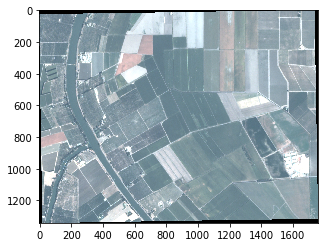

In [14]:
cropped_filename = add_suffix(pl_filename, 'cropped')
warp(pl_filename, cropped_filename, crop_filename=aoi_filename)

plt.figure(1, figsize=(5,5))
plt.imshow(image_to_display(load_masked_image(cropped_filename)))

<a id='visualize'></a>

## Visualize Ground Truth Data over Image

<a id='visualize-map'></a>
### Map

To ensure accurate alignment between the planet scene and the ground truth data, we will first visualize them overlayed in a geographic reference system. If the alignment is good, then we can move on to visualization and working in image space

Define Layer for cropped Planet scene

First we  project the cropped Planet scene to WGS84 for showing on the map. Then we adjust the scene for display and save as 8-bit jpeg. Finally, we define the image layer using the projected image bounds.

Leaflet appears to support local files if they are jpg ([src](https://gis.stackexchange.com/questions/82936/how-i-can-load-tilelayer-in-leaflet-framework-using-local-tiles))

In [15]:
# project cropped scene
dst_srs = 'epsg:4326' #WGS84

projected_filename = add_suffix(cropped_filename, 'proj')
warp(cropped_filename, projected_filename, dst_srs=dst_srs)

gdalwarp -s_srs epsg:32610 -t_srs epsg:4326 -overwrite data/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif data/20160831_180231_0e0e_3B_AnalyticMS_cropped_proj.tif


In [16]:
# save as jpg
img = image_to_display(load_masked_image(projected_filename))

# save image, delete before saving if it already exists
display_image = 'data/proj_img2.jpg'
if(os.path.isfile(display_image)): os.remove(display_image)
matplotlib.image.imsave(display_image, img)
# plt.imshow(img)

In [17]:
# Define the bounds for display of the image on the map
(minx, miny, maxx, maxy) = rasterio.open(projected_filename).bounds
sw = [miny, minx]
ne = [maxy, maxx]
print([sw, ne])

# Create image layer
local_img_url = display_image
image_layer = ipyl.ImageOverlay(url=local_img_url, bounds=[sw, ne])

[[38.29095983064804, -121.58530068766473], [38.328001399320975, -121.52415672841694]]


Define Layer for ground truth data

In [18]:
# Assign colors to classes

# Class ids from dwr_survey/09legend.pdf
agg_classes = ['G', 'R', 'F', 'P', 'T', 'D', 'C', 'V']

# colors determined using [colorbrewer2.org](http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3)
colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
class_colors = dict((a,c) for a,c in zip(agg_classes, colors))
def get_color(cls):
    return class_colors[cls]

In [19]:
feature_collection = {
    "type": "FeatureCollection",
    "features": ground_truth_data
}

for f in feature_collection['features']:
    feature_color = get_color(f['properties']['CLASS1'])
    f['properties']['style'] = {
        'color': 'black',
        'weight': 1,
        'fillColor': feature_color,
        'fillOpacity': 0.1}

feature_layer = ipyl.GeoJSON(data=feature_collection)

In [20]:
# display bounds box
aoi_feature = {
    'geometry':aoi['geometry'],
    "properties":{
            'style':{'color': 'red', 'fillOpacity': 0.0, 'weight': 1}},
    'type':u"Feature"}

aoi_layer = ipyl.GeoJSON(data=aoi_feature)

In [21]:
zoom = 13
center = [38.30933576918588, -121.55410766601564] # lat/lon
map_tiles = ipyl.TileLayer(url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')

data_map = ipyl.Map(
    center=center, 
    zoom=zoom,
    default_tiles = map_tiles
)

data_map.add_layer(image_layer)
data_map.add_layer(feature_layer)
data_map.add_layer(aoi_layer)

# display
data_map

Widget Javascript not detected.  It may not be installed or enabled properly.


Awesome! The data looks nicely registered to the imagery and the crop outlines don't appear to have changed much over the years. We can use the ground truth data for our crop segmentation study.

Although we converted the scene to WGS84 for display on the map, we want to perform analysis in the unprojected version, which is in a UTM coordinate system.

<a id='visualize-image'></a>

### Image Space

Image space is where we will be peforming image segmentation. In this section, as a part of visualization, we convert the ground truth data to OpenCV contours, which will be used in segmentation evaluation.

Ground truth data is stored as geojson, which only supports [EPSG:4326](http://spatialreference.org/ref/epsg/4326/). To visualize the ground truth data in image space, we must first project the features to the image crs, then convert them to image contours. We then display the contours over the image using OpenCV.

In [22]:
with rasterio.open(cropped_filename) as img:
    img_transform = img.transform
    img_srs = img.crs['init']

# project to image srs
projected_features = project_features(ground_truth_data, img_srs)

# convert projected features to contours
contours = [polygon_to_contour(f['geometry'], img_transform)
            for f in projected_features]
print(len(contours))

223


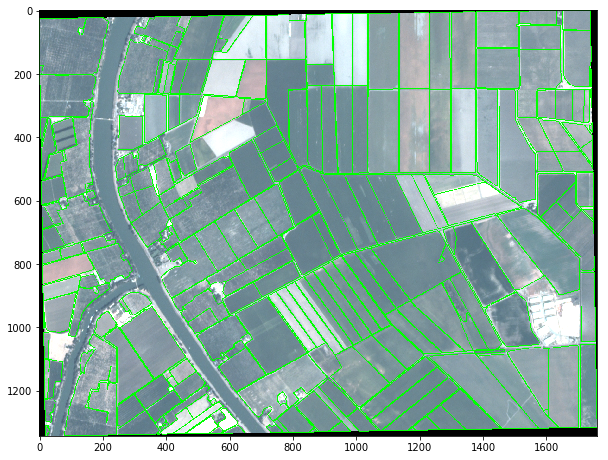

In [23]:
img = image_to_display(load_masked_image(cropped_filename), alpha=False)

plt.figure(1, figsize=(10,10))
plt.imshow(draw_contours(img, contours))

Ground truth contours look great and we are ready to move onto segmentation

<a id='segment'></a>

## Segment Image

#### Convert to TOA reflectance

Converting from TOA radiance to TOA reflectance normalizes the values to [0,1], which is required for the image processing algorithms. It also allows for comparison accross images.

The code for reading reflectance coefficients from metadata is pulled from [NDVI notebook](https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/ndvi/ndvi_planetscope.ipynb)

In [24]:
xmldoc = minidom.parse(pl_metadata_filename)
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

print(coeffs)

{1: 2.22720534111e-05, 2: 2.32869411017e-05, 3: 2.6177702949e-05, 4: 3.85793404296e-05}


In [25]:
def to_reflectance(masked_bands, coeffs):
    refl_bands = masked_bands.astype(np.double)
    for i in range(refl_bands.shape[2]):
        refl_bands[:,:,i] = refl_bands[:,:,i] * coeffs[i+1]
    return refl_bands

masked_bands = create_masked_bands(load_masked_image(cropped_filename))
refl_bands = to_reflectance(masked_bands, coeffs)
print(refl_bands.min())
print(refl_bands.max())

0.0472167532315
0.617793789596


Display reflectance bands

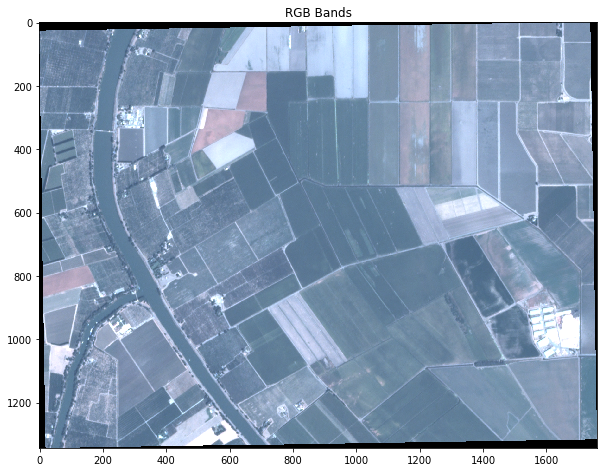

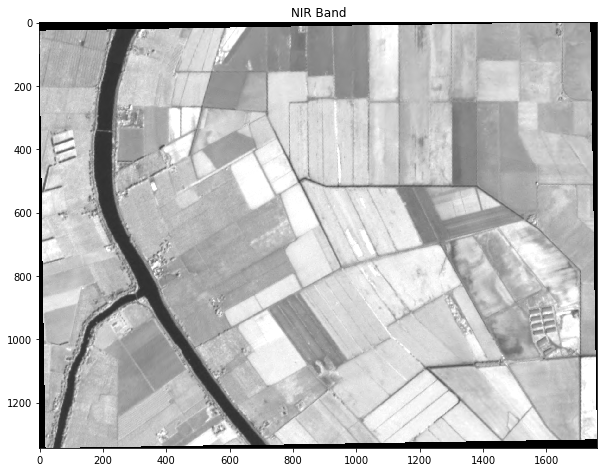

In [26]:
figsize = (10, 10)

rgb_bands = refl_bands[...,:3]
plt.figure(1,figsize=figsize)
plt.imshow(bands_to_display(rgb_bands))
plt.title('RGB Bands')

# repeat NIR band 3 times to get greyscale in RGB
nir_bands = refl_bands[:,:,(3,3,3)]
plt.figure(2, figsize=figsize)
plt.imshow(bands_to_display(nir_bands))
plt.title('NIR Band')

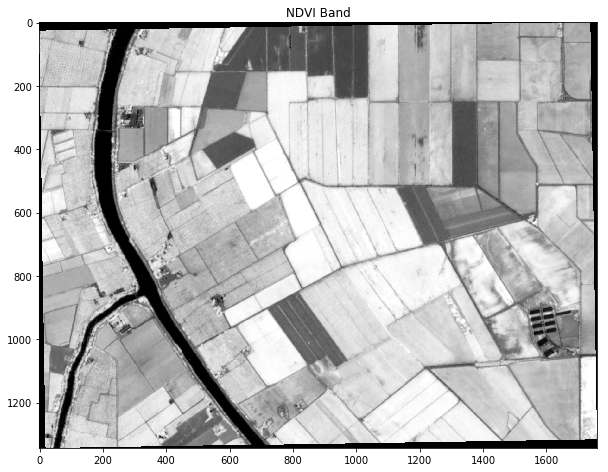

In [27]:
def calculate_ndvi(masked_bands):
    "Assumes bands are in RGBNIR order"
    r = refl_bands[...,1]
    nir = refl_bands[...,3]
    return (nir - r) / (nir + r)


ndvi_band = calculate_ndvi(refl_bands)

# Project 1band to 3 band for RGB
ndvi_bands = np.repeat(np.atleast_3d(ndvi_band), 3, axis=2)

plt.figure(1, figsize=figsize)

plt.imshow(bands_to_display(ndvi_bands))
plt.title('NDVI Band')

### SLIC Segmentation

SLIC segmentation clusters pixels in the (r,g,b) x (x,y,z) space. It requires 3 spectral bands. We will consider RGB and NIR separately.

In the results we see that the water features stand out more in the NIR image but both don't do a great job of segmenting the crops.

In [28]:
def normalize(masked_bands):
    old_min = np.percentile(masked_bands, 2)
    old_max = np.percentile(masked_bands, 98)
    new_min = 0
    new_max = 1
    scaled = linear_scale(masked_bands.astype(np.double),
                          old_min, old_max, new_min, new_max)
    return np.clip(scaled, new_min, new_max)

In [29]:
enforce_connectivity=True
slic_rgb_img = segmentation.slic(normalize(rgb_bands), enforce_connectivity=enforce_connectivity)
slic_nir_img = segmentation.slic(normalize(nir_bands), enforce_connectivity=enforce_connectivity)
slic_ndvi_img = segmentation.slic(normalize(ndvi_bands), enforce_connectivity=enforce_connectivity)

In [30]:
def add_contours(img, contours):
    n_img = img.astype(np.double)/256
    color = 1
    thickness = 2
    cv2.drawContours(n_img,contours,-1,color,thickness=thickness)
    return n_img

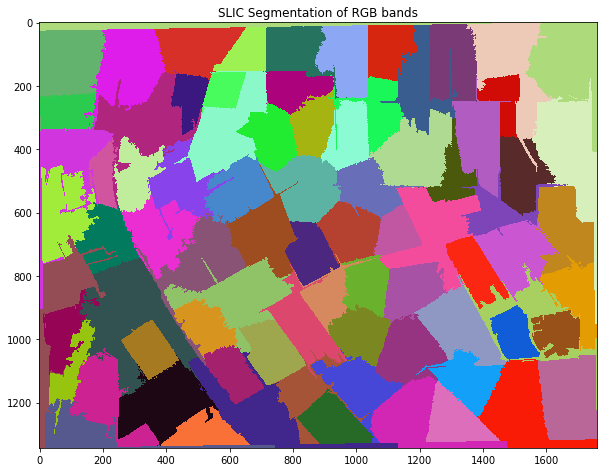

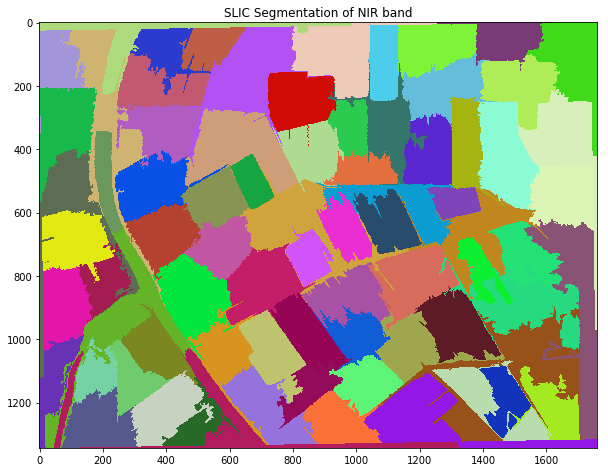

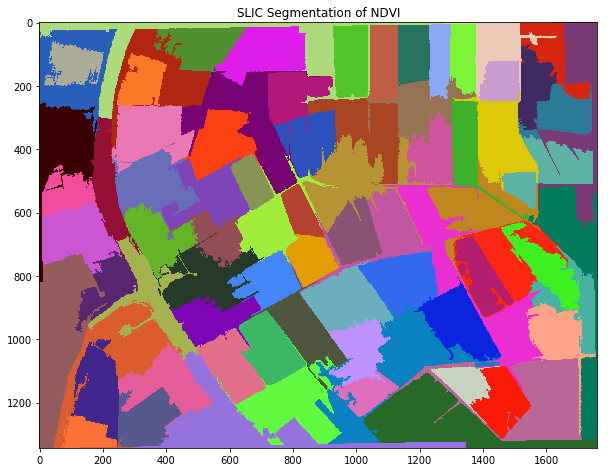

In [31]:
# https://gist.github.com/jgomezdans/402500
cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))

plt.figure(1,figsize=figsize)
# plt.imshow(add_contours(slic_rgb_img, contours), cmap=cmap)
plt.imshow(slic_rgb_img, cmap=cmap)
plt.title('SLIC Segmentation of RGB bands')

plt.figure(2,figsize=figsize)
# plt.imshow(add_contours(slic_nir_img, contours), cmap=cmap)
plt.imshow(slic_nir_img, cmap=cmap)
plt.title('SLIC Segmentation of NIR band')

plt.figure(3,figsize=figsize)
# plt.imshow(add_contours(slic_ndvi_img, contours), cmap=cmap)
plt.imshow(slic_ndvi_img, cmap=cmap)
plt.title('SLIC Segmentation of NDVI')

# Watershed Segmentation

Crops in our image don't have large spectral differences between them. Instead, the linear features (roads, trails) between crops are key features. Therefore, segmentation techniques that are more sensitive to edge features will be more successful. Watershed segmentation is sensitive to edges.

Denoise using Kmeans

Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)


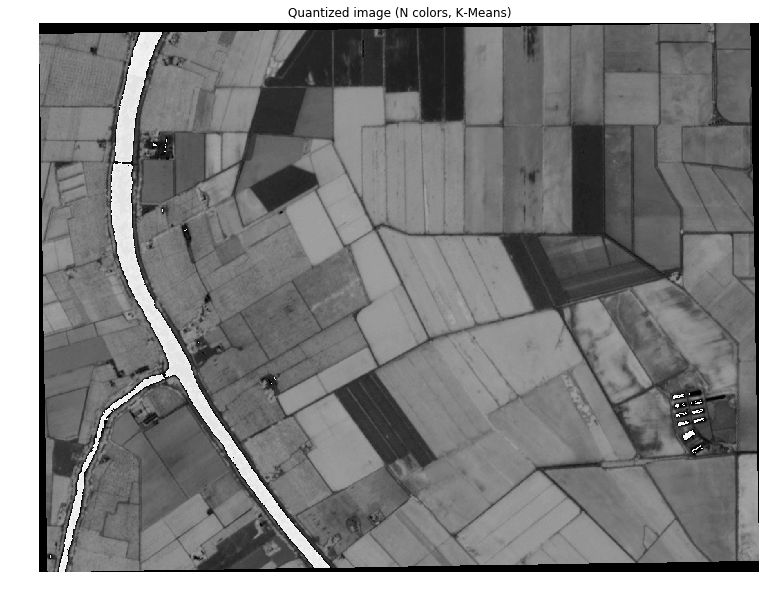

In [32]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

from sklearn.cluster import KMeans
from sklearn.utils import shuffle

def k_means_quantize(img, n_colors):

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))

    print("Fitting model on a small sub-sample of the data")
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    labels = kmeans.predict(image_array)
    
    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h, d))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image

    plt.figure(1, figsize=figsize)
    plt.clf()
    ax = plt.axes([0, 0, 1, 1])
    plt.axis('off')
    plt.title('Quantized image (N colors, K-Means)')
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

k_means_quantize(np.repeat(np.atleast_3d(ndvi_band), 3, axis=2), 64)